# Business Case Study: Netflix

### Problem Statement

Analyze the given dataset and generate insights that could help Netflix in deciding which type of shows/movies to produce and how they can grow the business in different countries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import squarify

### First Look

In [2]:
df = pd.read_csv('netflix.csv')
df


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


_____
# 1. Preparing the Data

### Re-indexing

In [3]:
# df_raw[df_raw['show_id'].str.contains(r'^s\d{1,4}$', regex=True)]['show_id'].count()
# The above command returns 8807, i.e. the length of the raw data.
# Therefore all values of show_id follow the same pattern of s####. It can replace the default index.

df['show_id'] = df['show_id'].str.strip('s').astype('Int64')
df.set_index('show_id', inplace=True)
df.tail()


,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


In [4]:
df.loc[df['rating'].str.contains(r' min')==True, 'duration'] = df.loc[df['rating'].str.contains(r' min')==True, 'rating']
df.loc[df['rating'].str.contains(r' min')==True, 'rating'] = np.nan

### Cleaning Numeric Columns

Split `date_added`(String) into `year_added`(Int64), `month_added`(Int64), etc. 

In [5]:
# 'date_added' is a string. Extracting year and month into new columns.
df['year_added'] = pd.to_datetime(df['date_added'].str.strip(), format='%B %d, %Y').dt.year
df['month_added'] = pd.to_datetime(df['date_added'].str.strip(), format='%B %d, %Y').dt.month
df['dayofweek_added'] = pd.to_datetime(df['date_added'].str.strip(), format='%B %d, %Y').dt.day_name()
df['quarter_added'] = pd.to_datetime(df['date_added'].str.strip(), format='%B %d, %Y').dt.quarter

df.drop(columns=['date_added'], inplace=True)

df['year_added'] = df['year_added'].astype('Int64')
df['month_added'] = df['month_added'].astype('Int64')
df['quarter_added'] = df['quarter_added'].astype('Int64')

df[['type', 'title', 'year_added', 'month_added', 'quarter_added', 'dayofweek_added']].tail()


,type,title,year_added,month_added,quarter_added,dayofweek_added
show_id,,,,,,
8803,Movie,Zodiac,2019,11,4,Wednesday
8804,TV Show,Zombie Dumb,2019,7,3,Monday
8805,Movie,Zombieland,2019,11,4,Friday
8806,Movie,Zoom,2020,1,1,Saturday
8807,Movie,Zubaan,2019,3,1,Saturday


Extract `length`(Int64) from `duration`(String)

In [6]:
df['duration'] = df['duration'].str.split()
df['duration'] = df['duration'].str[0]
df['duration'] = df['duration'].astype('Int64')

df.rename(columns={'duration':'length'}, inplace=True)

df[['type', 'title', 'length']].sort_values('type')


,type,title,length
show_id,,,
1,Movie,Dick Johnson Is Dead,90
5642,Movie,Under the Shadow,84
5640,Movie,Jim Gaffigan: Cinco,74
5639,Movie,Very Big Shot,109
5638,Movie,Clinical,104
...,...,...,...
2407,TV Show,Lenox Hill,1
5778,TV Show,Someone Like You,1
2406,TV Show,DC's Legends of Tomorrow,5


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8807 entries, 1 to 8807
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   type             8807 non-null   object
 1   title            8807 non-null   object
 2   director         6173 non-null   object
 3   cast             7982 non-null   object
 4   country          7976 non-null   object
 5   release_year     8807 non-null   int64 
 6   rating           8800 non-null   object
 7   length           8807 non-null   Int64 
 8   listed_in        8807 non-null   object
 9   description      8807 non-null   object
 10  year_added       8797 non-null   Int64 
 11  month_added      8797 non-null   Int64 
 12  dayofweek_added  8797 non-null   object
 13  quarter_added    8797 non-null   Int64 
dtypes: Int64(4), int64(1), object(9)
memory usage: 1.0+ MB


### Observations

1. Dataset Size and Structure

    - Total number of entries in Netflix archive: 8,807 titles

    - Dataset contains 14 columns including: type, title, director, cast, country, release year, rating, length, etc.

2. Data Completeness

    - All entries have complete data for: type, title, release_year, length, listed_in, description

    - Missing data exists in:

        - Director: 6,173 non-null out of 8,807 entries

        - Cast: 7,982 non-null entries

        - Country: 7,976 non-null entries

        - Rating: 8,800 non-null entries

3. Content Types

    - Content is divided into Movies and TV Shows

    - Duration is measured in minutes for movies and seasons for TV shows


_____
# 2. EDA: Exploring the Netflix Content Library

### Understanding Missing Data

In [8]:
missing_values_overall = pd.DataFrame({'count': len(df), 
                                       'nulls': df.isna().sum(), 
                                       'percent': df.isna().mean().round(4)*100})
missing_values_overall = missing_values_overall[missing_values_overall>0]

missing_values_by_type =\
lambda t: pd.DataFrame({'count': len(df[df['type']==t]),
                        'nulls': df[df['type']==t].isna().sum(),
                        'percent': df[df['type']==t].isna().mean().round(4)*100})

mv_tv = missing_values_by_type('TV Show')[missing_values_by_type('TV Show')['nulls'] > 0]
mv_movie = missing_values_by_type('Movie')[missing_values_by_type('Movie')['nulls'] > 0]

df_missing_values_by_type =\
pd.concat([mv_tv, mv_movie, missing_values_overall], 
           axis=1, keys=['TV Show', 'Movie', 'Overall']).round().astype('Int64')
df_missing_values_by_type.loc[['director', 'cast', 'country'],].rename_axis('column')


TV Show               Movie               Overall              
           count nulls percent count nulls percent   count nulls percent
column                                                                  
director    2676  2446      91  6131   188       3    8807  2634      30
cast        2676   350      13  6131   475       8    8807   825       9
country     2676   391      15  6131   440       7    8807   831       9

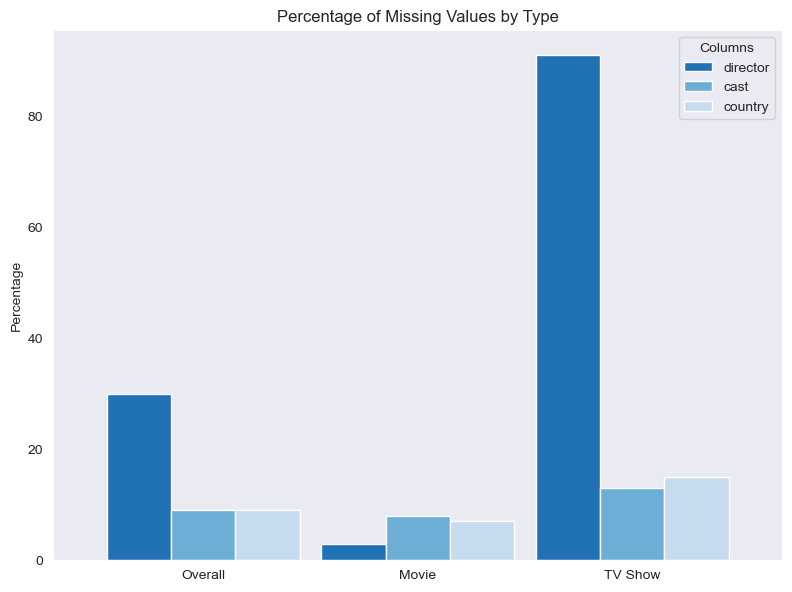

In [32]:
selected_data =\
df_missing_values_by_type.loc[['director', 'cast', 'country'], 
                              [('Overall', 'percent'), ('Movie', 'percent'), ('TV Show', 'percent')]].T
selected_data.index = selected_data.index.get_level_values(0)
selected_data.plot(kind='bar', 
                   figsize=(8, 6), 
                   rot=0, 
                   title='Percentage of Missing Values by Type',
                   ylabel='Percentage',
                   width=0.9,)
plt.legend(title='Columns')
plt.tight_layout(pad=1.0, h_pad=1.0)
sns.set_style('dark')
sns.set_palette('Blues_r', 3)
plt.show()


### 👆🏼 Observation

When we examine the dataset as a whole, we see Null values in 'director' column amounting to 30%. 

However, when we separate the data into 'TV Show' and 'Movies', we see that over 90% of TV shows don't have a director whereas the incidence of missing values in movies is negligibly low (only 3%).

This suggests that **Movies and TV Shows should be treated separately** during analysis down the line.

In [10]:
missing_values_by_year = lambda t:\
    pd.DataFrame({'percent': df[(df['type']=='TV Show') & (df['year_added']==t)].isna().mean().round(4)*100})
mv = lambda y:\
    missing_values_by_year(y)[missing_values_by_year(y)['percent'] > 0].rename(columns={'percent': str(y)})

df_missing_values_by_year = pd.DataFrame()
for y in range(2021, 2007, -1):
    if df_missing_values_by_year.empty:
        df_missing_values_by_year = mv(y)
    else:
        df_missing_values_by_year = pd.concat([df_missing_values_by_year, mv(y)], axis=1).round(1)

print("Missing Values by type='TV Show' (percentage)")
df_missing_values_by_year.fillna(chr(0x1F3C6))


Missing Values by type='TV Show' (percentage)


,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
director,87.1,89.8,93.8,94.2,91.1,95.4,88.5,100.0,80.0,🏆,🏆,🏆,🏆,100.0
cast,18.0,15.1,10.6,14.1,8.9,8.0,7.7,🏆,🏆,🏆,🏆,🏆,🏆,100.0
country,26.7,7.9,14.0,18.0,11.5,5.7,3.8,🏆,🏆,🏆,🏆,🏆,🏆,🏆
rating,🏆,🏆,🏆,0.2,🏆,0.6,🏆,🏆,🏆,🏆,🏆,🏆,🏆,🏆


In [11]:
missing_values_by_year = lambda t:\
        pd.DataFrame({'percent': df[(df['type']=='Movie') 
                              & (df['year_added']==t)].isna().mean().round(4)*100})
mv = lambda y: missing_values_by_year(y)[missing_values_by_year(y)['percent'] > 0].rename(columns={'percent': str(y)})

df_missing_values_by_year = pd.DataFrame()
for y in range(2021, 2007, -1):
    if df_missing_values_by_year.empty:
        df_missing_values_by_year = mv(y)
    else:
        df_missing_values_by_year =\
            pd.concat([df_missing_values_by_year, mv(y)], axis=1).round(1)

print("Missing Values by type='Movie' (percentage)")
df_missing_values_by_year.fillna(chr(0x1F4AF)) 


Missing Values by type='Movie' (percentage)


,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
director,3.0,2.3,3.0,3.8,1.9,7.5,3.6,5.3,💯,💯,💯,💯,💯,💯
cast,5.9,5.1,7.2,7.4,13.0,14.6,12.5,21.0,💯,💯,💯,💯,💯,💯
country,22.5,4.8,5.3,3.6,3.0,3.6,3.6,💯,💯,💯,💯,💯,💯,💯
rating,💯,💯,💯,💯,0.4,0.8,💯,💯,💯,💯,💯,💯,💯,💯


Looking at missing values by country further suggests that **Movies and TV Shows be treated separately** during any analysis concerning directors and cast.

_____
# 3. The World's Movie Theatre

### Major Film Industries of the World

In [12]:
total_by1_ = lambda country:df[df['country'].str.contains(country, na=False)]['country'].count()

for country in df['country'].value_counts().iloc[:15].index:
    print(f"{country}: {total_by1_(country)} ({100*total_by1_(country)/df['country'].count():.0f}%)")


United States: 3690 (46%)
India: 1046 (13%)
United Kingdom: 806 (10%)
Japan: 318 (4%)
South Korea: 231 (3%)
Canada: 445 (6%)
Spain: 232 (3%)
France: 393 (5%)
Mexico: 169 (2%)
Egypt: 117 (1%)
Turkey: 113 (1%)
Nigeria: 103 (1%)
Australia: 160 (2%)
Taiwan: 89 (1%)
Indonesia: 90 (1%)


#### Observation

This list represents the major film industries of the world. Too many independent industries — e.g. Telugu cinema which is the largest film industry in India by box office revenue — get subsumed under the broad categorisation of 'India'. 

#### Recommendation

1. Categorise films by language. This makes it possible to target significanly-sized liguistic diaspora across world markets. 

2. Invest in the production and acquisition of original local-language content with cross-cultural appeal to increase subscriber diversity, broaden subscriber base across regions, and improve subscriber retention/loyalty.


### Netflix by Audience

In [13]:
by_ratings = df['rating'].value_counts()
round(100 * by_ratings / by_ratings.sum(), 2)

rating
TV-MA       36.44
TV-14       24.55
TV-PG        9.81
R            9.08
PG-13        5.57
TV-Y7        3.80
TV-Y         3.49
PG           3.26
TV-G         2.50
NR           0.91
G            0.47
TV-Y7-FV     0.07
NC-17        0.03
UR           0.03
Name: count, dtype: float64

In [14]:
df['audience'] = df['rating'].copy()

audience = {'Children': ['TV-Y', 'TV-Y7', 'TV-Y7-FV', 'G'], 
            'Teens': ['TV-14', 'PG-13'],
            'Family': ['TV-G', 'TV-PG', 'PG'],
            'Adult': ['TV-MA', 'R', 'NC-17', 'UR', 'NR'],}

df['audience'] = df['audience'].apply(lambda x:\
                                            'Children' if x in audience['Children'] else 
                                            'Teens' if x in audience['Teens'] else 
                                            'Family' if x in audience['Family'] else 
                                            'Adult')

sizes = 100 * df['audience'].value_counts() / df['audience'].value_counts().sum()
sizes

audience
Adult       46.542523
Teens       30.089701
Family      15.555808
Children     7.811968
Name: count, dtype: float64

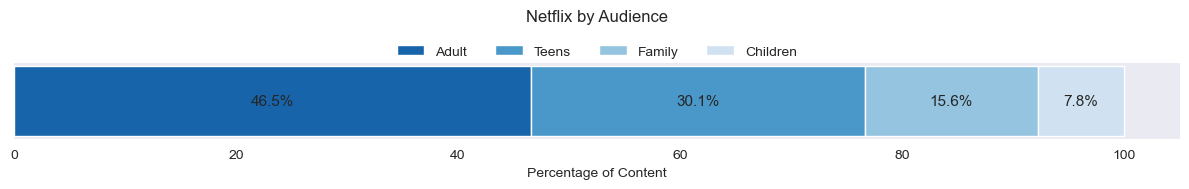

In [15]:
plt.figure(figsize=(12, 2))

left = 0
colors = sns.color_palette("Blues_r", len(sizes))
for i, (audience, percentage) in enumerate(sizes.items()):
    plt.barh(0, percentage, left=left, color=colors[i], label=f'{audience}')
    plt.text(left + percentage/2, 0, f'{percentage:.1f}%', ha='center', va='center', fontsize=11)
    left += percentage

plt.title('Netflix by Audience', pad=30)
plt.xlabel('Percentage of Content')
plt.yticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(0.5, 1.15), 
          loc='center', 
          ncol=len(sizes),
          frameon=False)

plt.tight_layout()
plt.show()

#### Observation

The visualization shows the distribution of Netflix content across different audience categories. 

- **Adult Content Dominance**: The largest portion of Netflix's content, 46.5%, is targeted towards adults, indicating a strong focus on mature audiences.

- **Teen and Family Content**: Content aimed at teens and families makes up 45.6%. This suggests a significant offering for younger audiences and family viewing.

#### Recommendation

- **Children's Content**: The smallest segment, 7.8%, is dedicated to children, highlights a potential area for growth if Netflix aims to expand its offerings for younger viewers.


### Movie Release Strategy

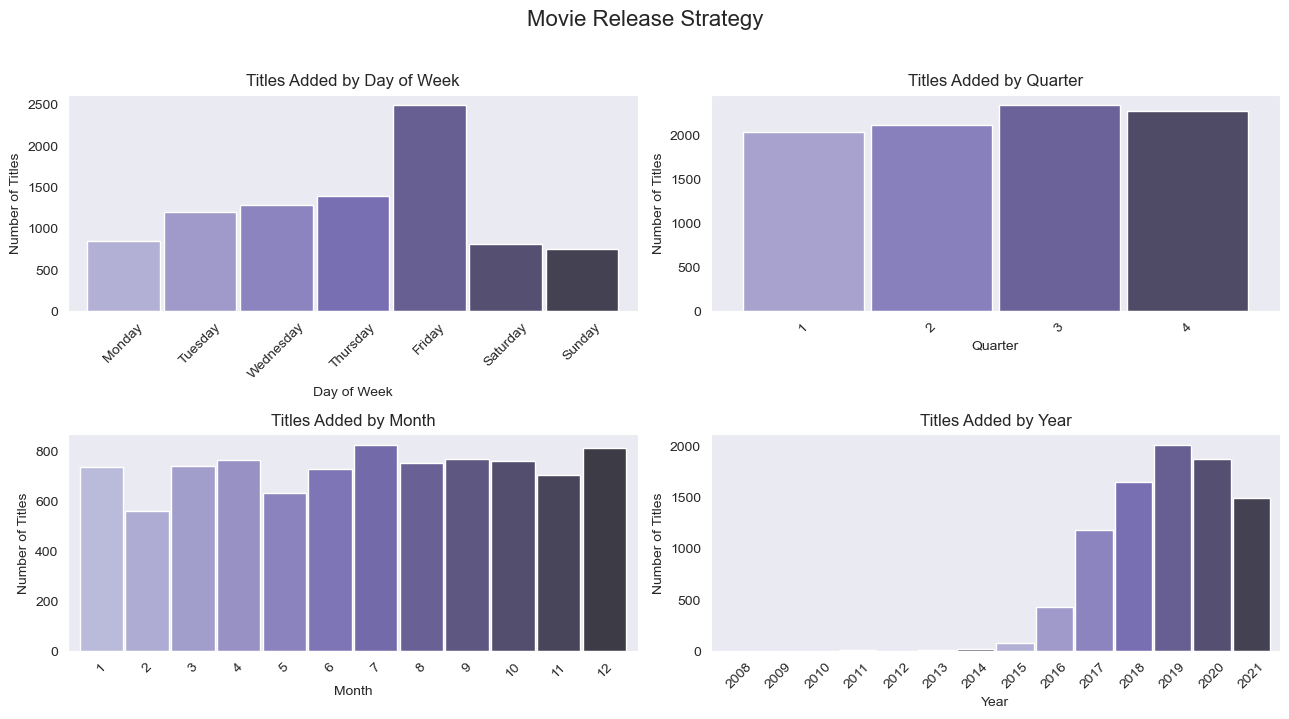

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(13, 7))
plt.suptitle('Movie Release Strategy', fontsize=16, y=1.02)
axes = axes.flatten()

# Plot 0: Titles Added by Day of Week (top-left)
df.groupby('dayofweek_added')['dayofweek_added'].value_counts()\
.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]\
.plot(kind='bar', ax=axes[0], width=0.95, color=sns.color_palette('Purples_d', 7))
axes[0].set_title('Titles Added by Day of Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Titles')
axes[0].tick_params(axis='x', rotation=45)

# Plot 1: Titles Added by Quarter (top-right)
df.groupby('quarter_added')['title'].count()\
.plot(kind='bar', ax=axes[1], width=0.95, color=sns.color_palette('Purples_d', 4))
axes[1].set_title('Titles Added by Quarter')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Number of Titles')
axes[1].tick_params(axis='x', rotation=45)

# Plot 2: Titles Added by Month (bottom-left)
df.groupby('month_added')['title'].count()\
.plot(kind='bar', ax=axes[2], width=0.95, color=sns.color_palette('Purples_d', 12))
axes[2].set_title('Titles Added by Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Titles')
axes[2].tick_params(axis='x', rotation=45)

# Plot 3: Titles Added by Year (bottom-right)
df.groupby(['year_added'])['title'].count()\
.plot(kind='bar', ax=axes[3], width=0.95, color=sns.color_palette('Purples_d', 7))
axes[3].set_title('Titles Added by Year')
axes[3].set_xlabel('Year')
axes[3].set_ylabel('Number of Titles')
axes[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Observations

1. Seeing how most titles are added on Fridays suggests a strategy to release new content ahead of the weekend, likely to capture viewers' leisure time.

2. Content additions are relatively consistent across all months and quarters, indicating a steady approach to content release throughout the year.

3. Particularly from 2016 to 2019, there has been significant growth in the annual acquisition of titles. However, we need to research further as to why there very few titles added in the preceding years.


_____
# 4. The Netflix Era

#### Statement

Netflix announced online streaming of movies as a new business model in 2007. That changed the way individuals interact with the movie industry forever. Before Netflix, people used to go to theatres to watch movies in groups. After Netflix, movies go to individuals on their personal devices. 

Let us see what we can learn by exploring the eras **Before Netflix (15 years from 1992 to 2006)** and **After Netflix (15 years from 2007 to 2021)**

#### Assumption

Movies produced in United States, United Kingdom and Australia are '**English Films**'. Movies produced in any other country are categorised as '**Foreign Films**'.

In [17]:
filter1 = (df['release_year'] >= 1992) & (df['release_year'] < 2007)
filter2 = df['type']=='Movie'
filter3 = df['country'].str.contains(r'United States|United Kingdom|Australia', na=False)
filtered_df1 = df[filter1 & filter2 & filter3]\
    .groupby('release_year')['title'].count().sort_index(ascending=True)

filter1 = df['release_year'] >= 2007
filter2 = df['type']=='Movie'
filter3 = df['country'].str.contains(r'United States|United Kingdom|Australia', na=False)
filtered_df2 = df[filter1 & filter2 & filter3]\
    .groupby('release_year')['title'].count().sort_index(ascending=True)

filter1 = (df['release_year'] >= 1992) & (df['release_year'] < 2007)
filter2 = df['type']=='Movie'
filter3 = df['country']\
    .str.contains(r'India|Japan|South Korea|Canada|Spain|\
                    France|Mexico|Egypt|Turkey|Nigeria|Taiwan|Indonesia', na=False)
filtered_df3 = df[filter1 & filter2 & filter3].groupby('release_year')['title'].count().sort_index(ascending=True)

filter1 = df['release_year'] >= 2007
filter2 = df['type']=='Movie'
filter3 = df['country']\
    .str.contains(r'India|Japan|South Korea|Canada|Spain|\
                    France|Mexico|Egypt|Turkey|Nigeria|Taiwan|Indonesia', na=False)
filtered_df4 = df[filter1 & filter2 & filter3].groupby('release_year')['title'].count().sort_index(ascending=True)


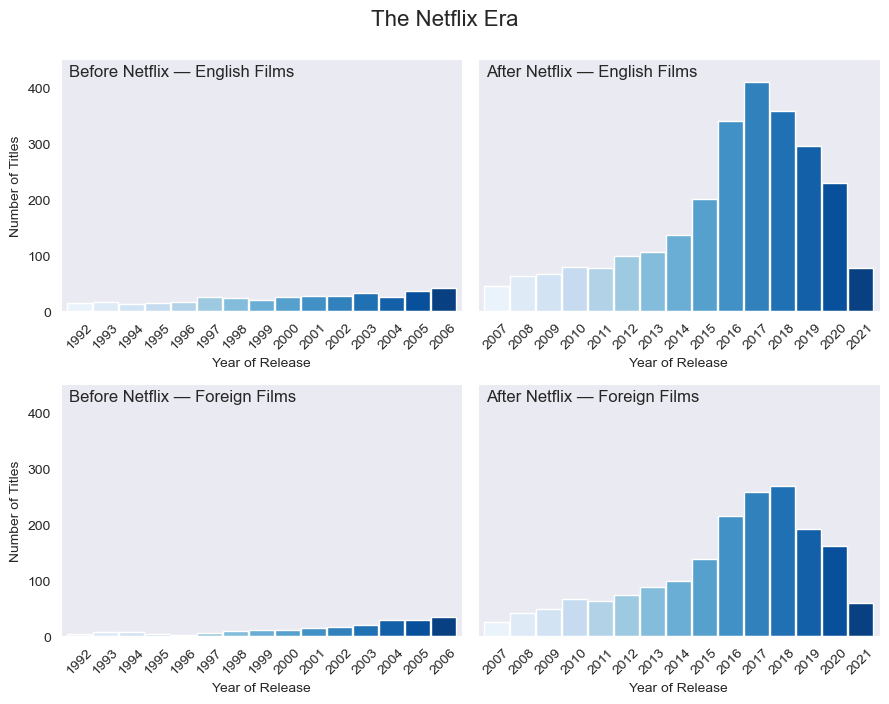

In [18]:
def create_bar_plot(ax, data, title, show_y_axis=True):
    data.plot(kind='bar', ax=ax,
              xlabel='Year of Release', 
              ylabel='Number of Titles' if show_y_axis else '',
              rot=45, width=0.95,
              color=colors)
        
    ax.set_title(title, loc='left', y=0.9, x=0.02, fontsize=12)
    ax.set_ylim(0, y_max)
    ax.yaxis.set_visible(show_y_axis)

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

datasets = [filtered_df1, filtered_df2, filtered_df3, filtered_df4]
y_max = max(df.max() for df in datasets) * 1.1

colors = sns.color_palette('Blues', 15)

plot_configs = [
    {'data': filtered_df1, 'title': 'Before Netflix — English Films', 'show_y_axis': True},
    {'data': filtered_df2, 'title': 'After Netflix — English Films', 'show_y_axis': False},
    {'data': filtered_df3, 'title': 'Before Netflix — Foreign Films', 'show_y_axis': True},
    {'data': filtered_df4, 'title': 'After Netflix — Foreign Films', 'show_y_axis': False}
]

for ax, config in zip(axes, plot_configs):
    create_bar_plot(ax, **config)

plt.suptitle('The Netflix Era', fontsize=16, y=1.0)
plt.tight_layout()
plt.show()

#### Observations

1. **Increased Film Releases**

    - Both English and foreign films saw a significant increase in the number of titles released after Netflix's streaming model began in 2007. This indicates a broader distribution and accessibility of films.

2. **Foreign Films Expansion**

    - The growth in foreign film releases is particularly notable, suggesting that Netflix has played a role in increasing the visibility and availability of international content.

#### Recommendation

Here, I would cite [Christopher Anderson's Long Tail theory](https://www.investopedia.com/terms/l/long-tail.asp) to back my recommendation that Netflix should consider investing in older titles to fill the visible gap in the graph. By expanding the library with niche and classic films, Netflix can cater to diverse tastes and capture long-tail demand, enhancing viewer engagement and satisfaction. This strategy can unlock new revenue streams by attracting audiences interested in less mainstream content.


## How has the average show time of movies changed after the advent of online streaming?

### Movie length analysis before and after the advent of online streaming platforms

In [19]:
filter1 = (df['release_year'] >= 1992) & (df['release_year'] < 2007)
filter2 = df['type']=='Movie'
filter3 = df['country'].str.contains(r'United States|United Kingdom|Australia', na=False)
filtered_df1 = df[filter1 & filter2 & filter3]['length']

filter1 = (df['release_year'] >= 2007)
filter2 = df['type']=='Movie'
filter3 = df['country'].str.contains(r'United States|United Kingdom|Australia', na=False)
filtered_df2 = df[filter1 & filter2 & filter3]['length']

filter1 = (df['release_year'] >= 1992) & (df['release_year'] < 2007)
filter2 = df['type']=='Movie'
filter3 = df['country'].str.contains(r'India|Japan|South Korea|Canada|Spain|\
    France|Mexico|Egypt|Turkey|Nigeria|Taiwan|Indonesia', na=False)
filtered_df3 = df[filter1 & filter2 & filter3]['length']

filter1 = (df['release_year'] >= 2007)
filter2 = df['type']=='Movie'
filter3 = df['country'].str.contains(r'India|Japan|South Korea|Canada|Spain|\
    France|Mexico|Egypt|Turkey|Nigeria|Taiwan|Indonesia', na=False)
filtered_df4 = df[filter1 & filter2 & filter3]['length']


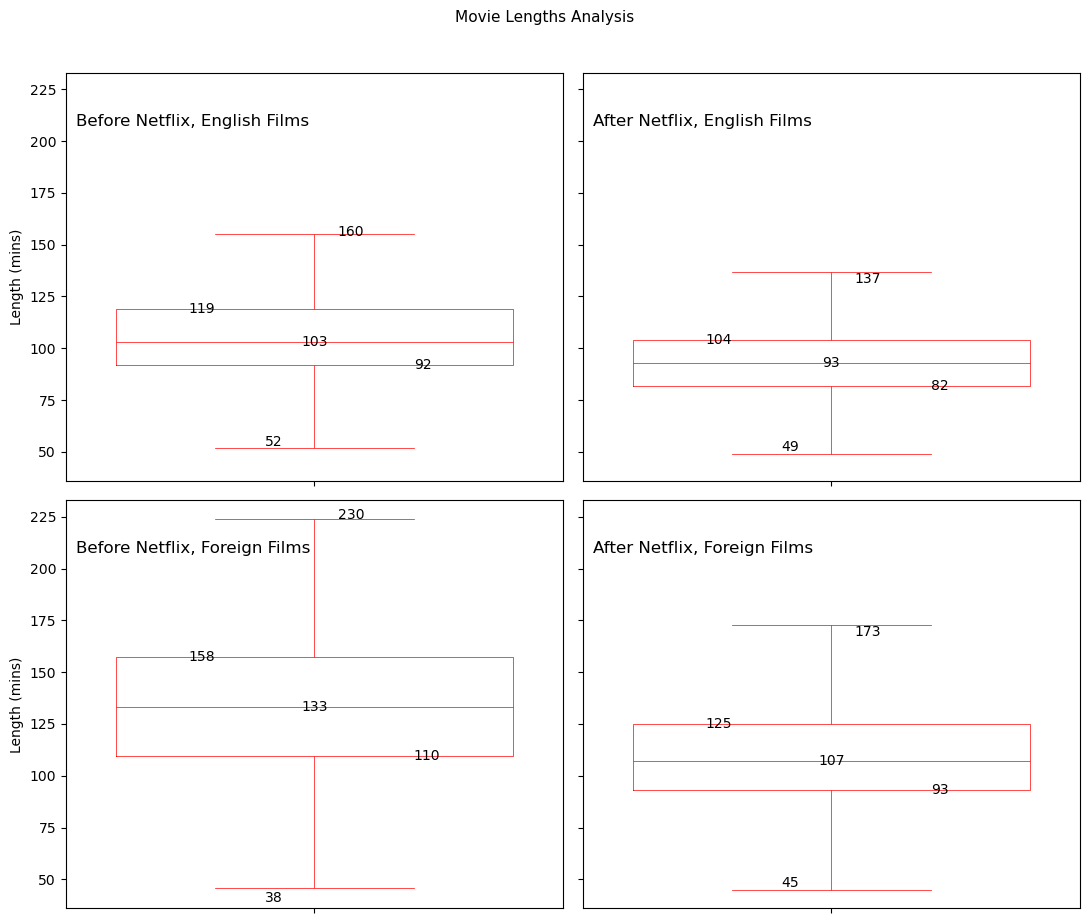

In [20]:
def add_boxplot_annotations(ax, data):
    Q1 = data.quantile(0.25)
    Q2 = data.quantile(0.50)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    ax.text(-0.2, Q3, f'{Q3:.0f}', horizontalalignment='right', verticalalignment='center')
    ax.text(0.0, Q2, f'{Q2:.0f}', horizontalalignment='center', verticalalignment='center')
    ax.text(0.2, Q1, f'{Q1:.0f}', horizontalalignment='left', verticalalignment='center')
    
    ax.text(-0.1, Q1-(IQR*1.5), f'{Q1-(IQR*1.5):.0f}', horizontalalignment='left', verticalalignment='bottom')
    ax.text(0.1, Q3+(IQR*1.5), f'{Q3+(IQR*1.5):.0f}', horizontalalignment='right', verticalalignment='top')

plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(11, 9), sharey=True, facecolor='white')
plt.suptitle('Movie Lengths Analysis', fontsize=11, y=1.02)

axes = axes.flatten()
for ax in axes:
    ax.set_facecolor('white')

datasets = [filtered_df1, filtered_df2, filtered_df3, filtered_df4]
titles = ['Before Netflix, English Films',
          'After Netflix, English Films',
          'Before Netflix, Foreign Films',
          'After Netflix, Foreign Films']

for i, (data, title) in enumerate(zip(datasets, titles)):
    sns.boxplot(y=data, ax=axes[i], color='r', fill=False, linewidth=0.5, showfliers=False)
    axes[i].set_title(title, loc='left', y=0.85, x=0.02, fontsize=12)
    axes[i].set_ylabel('Length (mins)')
    add_boxplot_annotations(axes[i], data)
    
plt.tight_layout()
plt.show()

#### Observations

1. **Average Lengths ↘**

    - After Netflix, both English and foreign films tend to be shorter on average. This could reflect a shift towards more concise storytelling, possibly to cater to the preferences of streaming audiences who favor shorter, more digestible content.

2. **Variability ↘**

    - The variability in movie lengths has decreased after Netflix for both English and foreign films, indicating a trend towards standardization in film duration.

3. **Median Lengths ↘**

    - The median length of films has decreased slightly in the post-Netflix era, aligning with the trend of shorter films.

#### Recommendation

Overall, these insights suggest that Netflix's streaming model has influenced not only the volume of content but also the nature of film production, with a focus on shorter, more consistent movie lengths to suit streaming audiences. Focus on producing shorter films and series episodes to align with the trend of concise storytelling. This can improve viewer engagement, especially for mobile and on-the-go consumption.


_____
# 5. Netflix has Something for Everyone

In [21]:
movie_dictionary = dict()
ignore_list = ['the', 'and', 'his', 'with', 'while', 'them', 'her', 'for', 'their', 'when', 'this', 'from', 'after', 'that', 'who', 'but', 'into', 'they', 'she', 'him', 'are', 'has', 'its', 'not']

for description in df['description']:
    for word in description.lower().split():
        word = word.strip(',.')
        if len(word) >= 3 and word not in ignore_list:
            if word in movie_dictionary.keys():
                movie_dictionary[word] += 1
            else:
                movie_dictionary[word] = 1

movie_dictionary = {k: v for k, v in sorted(movie_dictionary.items(), key=lambda item: item[1], reverse=True)}


Analysing the frequency of keywords across descriptions of 8,800+ titles points to some interesting insights.

#### Major prevalent themes

- Family-oriented content is prominent ("family": 566, "father": 238, "mother": 166, "parents": 79)

- Strong focus on relationships ("love": 494, "friends": 431, "relationship": 111)

- Youth-focused content ("young": 728, "school": 312, "teen": 208)

#### Genre indicators

- Drama/Action words are frequent ("against": 208, "fight": 152)

- Crime/Mystery elements ("murder": 192, "mysterious": 183, "crime": 162)

- Comedy is significant ("comedy": 174, "stand-up": 143, "comedian": 126)

#### Key observations

- Netflix content heavily emphasizes human relationships and personal journeys

- There's a good balance between serious themes (crime, mystery) and lighter content (comedy, family)

- Strong focus on youth and coming-of-age stories

- This suggests Netflix's content strategy focuses on relatable human stories across various genres with emphasis on family, youth, and personal narratives.


### Examining TV Shows and Movies by Genre

In [22]:
df_genres_tvshows = df[df['type']=='TV Show']['listed_in'].str.split(', ')
df_genres_tvshows = df_genres_tvshows.explode('listed_in')

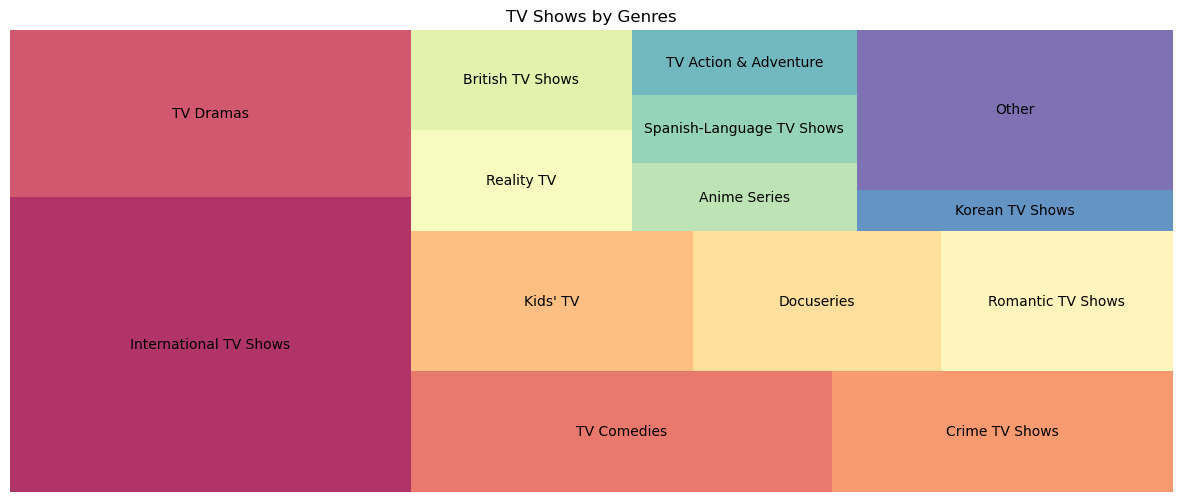

In [23]:
chart_this = df_genres_tvshows.value_counts(normalize=True) * 100
major_genres = chart_this[~(chart_this < 2)]
other_genres = pd.Series({'Other': chart_this[chart_this < 2].sum()})
chart_this = pd.concat([major_genres, other_genres])

plt.figure(figsize=(15, 6))
squarify.plot(sizes=chart_this.values, label=chart_this.index, alpha=.8, color=plt.cm.Spectral(np.linspace(0, 1, len(chart_this))))
plt.axis('off')
plt.title('TV Shows by Genres')
plt.show()


In [24]:
df_genres_movies = df[df['type']=='Movie']['listed_in'].str.split(', ')
df_genres_movies = df_genres_movies.explode('listed_in')

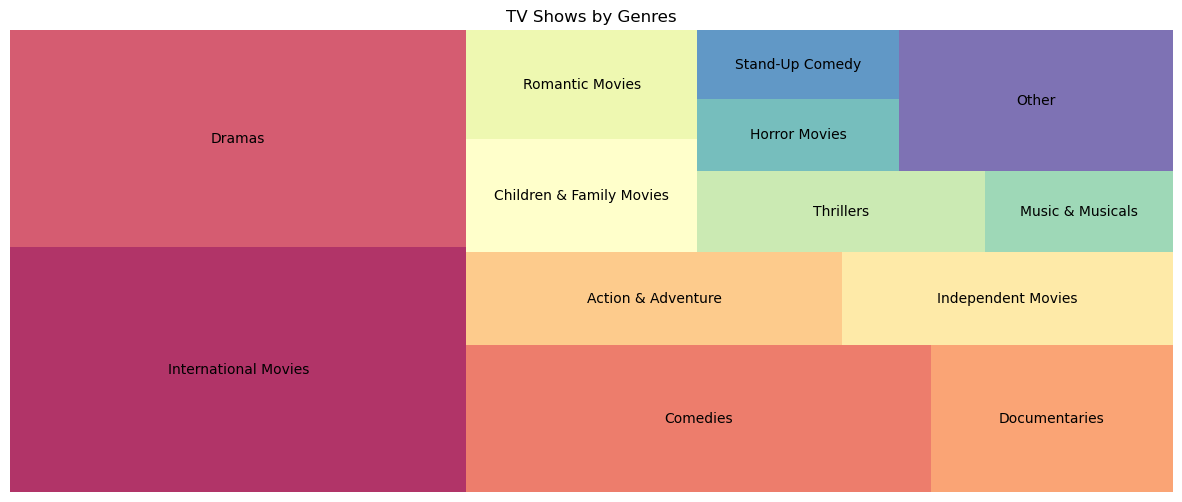

In [25]:
chart_this = df_genres_movies.value_counts(normalize=True) * 100
major_genres = chart_this[~(chart_this < 2)]
other_genres = pd.Series({'Other': chart_this[chart_this < 2].sum()})
chart_this = pd.concat([major_genres, other_genres])

plt.figure(figsize=(15, 6))
squarify.plot(sizes=chart_this.values, label=chart_this.index, alpha=.8, color=plt.cm.Spectral(np.linspace(0, 1, len(chart_this))))
plt.axis('off')
plt.title('TV Shows by Genres')
plt.show()


#### Recommendation

Once again citing [Christopher Anderson's Long Tail theory](https://www.investopedia.com/terms/l/long-tail.asp) to back my recommendation, Netflix should consider expanding the content library to a far wider range of niche genres rather than being limited to the "big hits". This will allow Netflix to cater to diverse tastes and capture long-tail demand, enhancing viewer engagement and satisfaction. This strategy can unlock new revenue streams by attracting audiences interested in less mainstream content.


_____
# 6. The Film Fraternity

In [26]:
country='India'

filter1 = df['release_year'] >= 2007
filter2 = df['country'].str.contains(country, na=False)
filter3 = df['type']=='Movie'


### Audience Distribution: Who are we creating for?

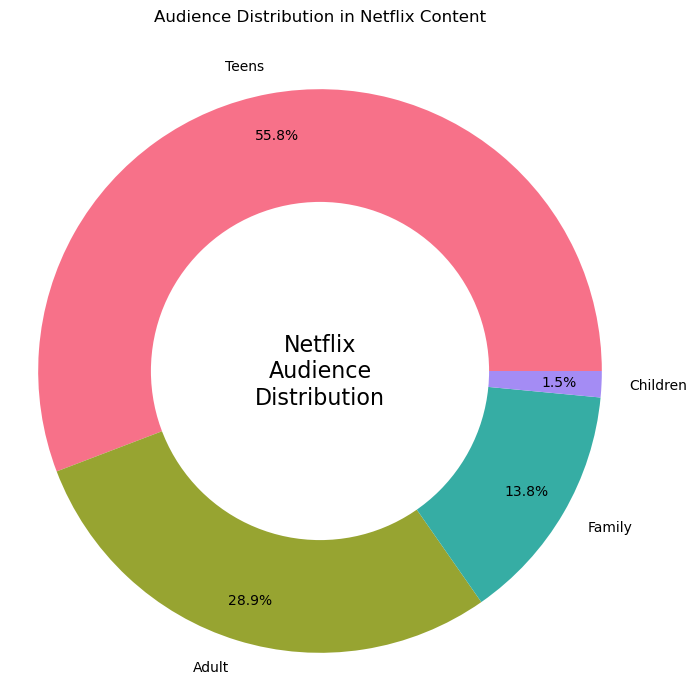

In [27]:
df_movies_by_country = df[filter1 & filter2 & filter3].copy()
df_movies_by_country.drop(columns=['month_added', 'dayofweek_added', 'quarter_added', 
                                   'type', 'country', 'rating', 'description'], inplace=True)

audience_pcts = (100 * df_movies_by_country['audience'].value_counts() / 
                df_movies_by_country['audience'].value_counts().sum()).round(1)

# Visualise audiences as a donut chart
plt.figure(figsize=(8, 8))
colors = sns.color_palette("husl", len(audience_pcts))

wedges, texts, autotexts = plt.pie(audience_pcts, 
                            labels=audience_pcts.index,
                            colors=colors,
                            autopct='%1.1f%%',
                            pctdistance=0.85,
                            wedgeprops=dict(width=0.6))

centre_circle = plt.Circle((0,0), 0.60, fc='white')
plt.gca().add_artist(centre_circle)

plt.text(0, 0, 'Netflix\nAudience\nDistribution', 
         ha='center', va='center', fontsize=16)

plt.title('Audience Distribution in Netflix Content', pad=30)
plt.axis('equal')
plt.show()


### Network Analysis: Who is creating with whom?

In [28]:
df_movies_by_country['cast'] = df_movies_by_country['cast'].str.split(', ')
df_movies_by_country = df_movies_by_country.explode('cast')

df_movies_by_country['director'] = df_movies_by_country['director'].str.split(', ')
df_movies_by_country = df_movies_by_country.explode('director')

df_movies_by_country['listed_in'] = df_movies_by_country['listed_in'].str.split(', ')
df_movies_by_country = df_movies_by_country.explode('listed_in')

df_movies_by_country = df_movies_by_country.drop_duplicates(subset=['title', 'director', 'cast'])

df_movies_by_country

,title,director,cast,release_year,length,listed_in,year_added,audience
show_id,,,,,,,,
30,Paranoia,Robert Luketic,Liam Hemsworth,2013,106,Thrillers,2021,Teens
30,Paranoia,Robert Luketic,Gary Oldman,2013,106,Thrillers,2021,Teens
30,Paranoia,Robert Luketic,Amber Heard,2013,106,Thrillers,2021,Teens
30,Paranoia,Robert Luketic,Harrison Ford,2013,106,Thrillers,2021,Teens
30,Paranoia,Robert Luketic,Lucas Till,2013,106,Thrillers,2021,Teens
...,...,...,...,...,...,...,...,...
8807,Zubaan,Mozez Singh,Manish Chaudhary,2015,111,Dramas,2019,Teens
8807,Zubaan,Mozez Singh,Meghna Malik,2015,111,Dramas,2019,Teens
8807,Zubaan,Mozez Singh,Malkeet Rauni,2015,111,Dramas,2019,Teens


In [29]:
actor_director_pairs = df_movies_by_country.groupby(['director', 'cast']).size()\
    .reset_index(name='collaboration_count')\
    .sort_values('collaboration_count', ascending=False).head(40)

actor_director_pairs = actor_director_pairs[
    (actor_director_pairs['director'].str.len() > 0) & 
    (actor_director_pairs['cast'].str.len() > 0)]

actor_director_collaborations = df_movies_by_country\
    .groupby(['director', 'cast'])['title'].agg(list)\
    .reset_index(name='movies')

full_analysis = actor_director_pairs.merge(
    actor_director_collaborations,
    on=['director', 'cast'])

full_analysis.head(10)

,director,cast,collaboration_count,movies
0,Rajiv Chilaka,Julie Tejwani,4,"[Chhota Bheem And The Broken Amulet, Chhota Bh..."
1,Rajiv Chilaka,Rajesh Kava,4,"[Chhota Bheem And The Broken Amulet, Chhota Bh..."
2,Zoya Akhtar,Farhan Akhtar,3,"[Dil Dhadakne Do, Luck by Chance, Zindagi Na M..."
3,Vishal Bhardwaj,Shahid Kapoor,3,"[Kaminey, Haider, Rangoon]"
4,Rajiv Chilaka,Jigna Bhardwaj,3,"[Chhota Bheem And The Broken Amulet, Chhota Bh..."
5,Milan Luthria,Emraan Hashmi,3,"[Once Upon a Time in Mumbaai, The Dirty Pictur..."
6,Rajkumar Hirani,Boman Irani,3,"[3 Idiots, Sanju, PK]"
7,David Dhawan,Anupam Kher,3,"[Chashme Baddoor, Judwaa 2, Chashme Buddoor]"
8,Rajiv Chilaka,Rupa Bhimani,3,"[Chhota Bheem And The Broken Amulet, Chhota Bh..."
9,Prakash Jha,Manoj Bajpayee,3,"[Satyagraha, Raajneeti, Aarakshan]"


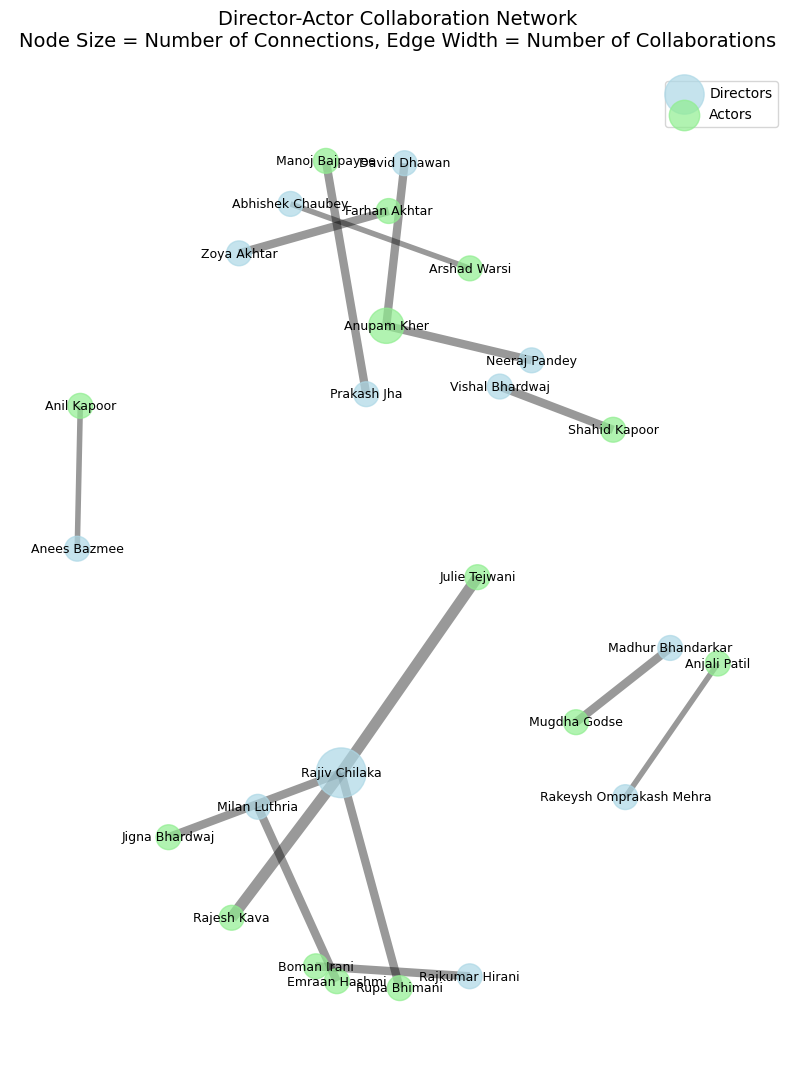


Network Insights:
-----------------
Total number of collaborations: 15
Number of unique people: 26

Most connected people (by degree centrality):
Rajiv Chilaka: 0.160
Anupam Kher: 0.080
Julie Tejwani: 0.040
Rajesh Kava: 0.040
Zoya Akhtar: 0.040

Strongest collaborations:
Rajiv Chilaka - Julie Tejwani: 4 collaborations
Rajiv Chilaka - Rajesh Kava: 4 collaborations
Rajiv Chilaka - Jigna Bhardwaj: 3 collaborations
Rajiv Chilaka - Rupa Bhimani: 3 collaborations
Zoya Akhtar - Farhan Akhtar: 3 collaborations


In [30]:
# Create Network graph
# Disclaimer: This graph has been generated with help from Claude 3.5 Sonnet LLM
G = nx.Graph()

# Add edges with weights
for _, row in actor_director_pairs.head(15).iterrows():
    G.add_edge(row['director'], row['cast'], weight=row['collaboration_count'])

plt.figure(figsize=(10, 13))

# Calculate node sizes based on degree centrality
degree_centrality = nx.degree_centrality(G)
node_sizes = [degree_centrality[node] * 8000 for node in G.nodes()]

# Calculate edge widths based on collaboration count
edge_widths = [G[u][v]['weight'] * 2 for u, v in G.edges()]

# Use spring layout with adjusted parameters for better spacing
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Draw the network with different colors for directors and actors
directors = [node for node in G.nodes() if node in actor_director_pairs['director'].unique()]
actors = [node for node in G.nodes() if node in actor_director_pairs['cast'].unique()]

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=directors, node_color='lightblue', 
                      node_size=[degree_centrality[d] * 8000 for d in directors], alpha=0.7, label='Directors')
nx.draw_networkx_nodes(G, pos, nodelist=actors, node_color='lightgreen', 
                      node_size=[degree_centrality[a] * 8000 for a in actors], alpha=0.7, label='Actors')

# Draw edges and labels
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=9)

plt.title('Director-Actor Collaboration Network\nNode Size = Number of Connections, Edge Width = Number of Collaborations', 
          pad=20, size=14)
plt.legend()
plt.axis('off')
plt.show()

# Print network metrics
print("\nNetwork Insights:")
print("-----------------")
print(f"Total number of collaborations: {G.number_of_edges()}")
print(f"Number of unique people: {G.number_of_nodes()}")

# Find most central nodes
print("\nMost connected people (by degree centrality):")
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
for person, centrality in sorted_centrality[:5]:
    print(f"{person}: {centrality:.3f}")

# Find strongest collaborations
print("\nStrongest collaborations:")
strongest_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
for edge in strongest_edges[:5]:
    print(f"{edge[0]} - {edge[1]}: {edge[2]['weight']} collaborations")

Here, I have used a Network Graph to explore connections between directors and actors. Note:

- **Node Size**: Larger the node, more connections with different people. Helps identify the most "collaborative" people in the network

- **Edge Width**: Thicker the lines, more collaborations between that director-actor pair. Shows strength of working relationships

- **Node Colors**: Different colors for directors vs actors help identify roles and patterns of collaboration

- **Node Position**: Nodes that are closer together indicate more likely to be connected

- **Clusters** indicate groups that frequently work together


### How to analyse the network (depending on the input country)

1. Central Players

    - Who has the largest node? They're the most connected (e.g. India: Rajiv Chilaka)

    - Are there directors who work with many different actors? (e.g. India: Rajiv Chilaka)

    - Are there actors who work with many different directors? (e.g. India: Anupam Kher works with David Dhawan and Neeraj Pandey)

2. Strength of Partnerships

    - Thickest edges represent director-actor pairs who frequently collaborate (e.g. India: Zoya Akhtar-Farhan Akhtar)

3. Clusters

    - Groups of nodes close together might indicate "film families" or preferred collaborators

4. Bridges

    - Nodes that connect different clusters suggest these people might be "connectors" in the industry

5. Isolated Pairs

    - Pairs far from others might indicate exclusive working relationships


_____
# 7. Summary: Insights and Recommendations

To summarise, here are the key observations and recommendations from the Netflix business case study:

## Key Insights 🎗️

### 1️⃣ Content Release Strategy

- Most titles are added on Fridays to capture weekend viewing
- Content additions are consistent across months/quarters
- Significant growth in title acquisitions from 2016-2019

### 2️⃣ Pre vs Post Netflix Era (1992-2006 vs 2007-2021)

- Both English and foreign films saw significant increase after 2007
- Notable growth in foreign film releases showing increased international content
- Movie lengths have decreased on average after Netflix
- Less variability in movie lengths indicating standardization
- Shorter median lengths aligning with streaming preferences

### 3️⃣ Content Themes & Genres

- Strong focus on family-oriented content
- Emphasis on relationships and youth/coming-of-age stories
- Good balance between serious (crime/mystery) and light content (comedy)
- Content strategy focuses on relatable human narratives

## Recommendations 🎗️

### 1️⃣ Content Strategy

- Invest in older titles to fill visible gaps in the library
- Focus on producing shorter films/episodes for streaming audiences
- Continue expanding international content offerings
- Maintain balance between serious and light content

### 2️⃣ Content Release Strategy

- Continue Friday releases to maximize weekend viewing
- Maintain consistent content additions throughout the year
- Further expand foreign film acquisitions

### 3️⃣ Long-term Growth

- Apply Long Tail theory to expand niche/classic film offerings
- Keep standardizing content length for streaming preferences
- Continue focus on relatable human stories across genres
- Maintain strong emphasis on family and youth content

### 4️⃣ User Experience

- Optimize content for mobile/on-the-go consumption
- Focus on concise storytelling to improve engagement
- Continue diversifying content across genres
